## House Price Prediction using Advanced Linear Regression

In [518]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib
%matplotlib inline
# Matlab-style plotting
import matplotlib.pyplot as plt  
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
#for some statistics
from scipy import stats
from scipy.stats import norm, skew 

In [519]:
# Import Data
data = pd.read_csv('train.csv')

In [520]:
# Display the first five rows of the dataset.
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [521]:
# check Data before feature drop
data.shape

(1460, 81)

In [522]:
#Now drop the 'Id' colum since it's unnecessary for the prediction process.
data.drop("Id", axis = 1, inplace = True)

In [523]:
# check Data after feature drop
data.shape

(1460, 80)

## Data prepration and Outlier processing

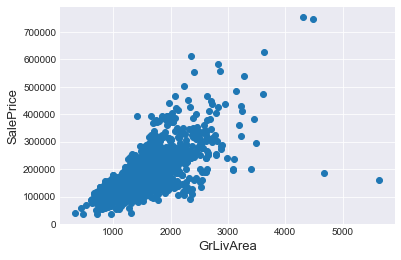

In [524]:
fig, ax = plt.subplots()
ax.scatter(x = data['GrLivArea'], y = data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers. Therefore, we can safely delete them.

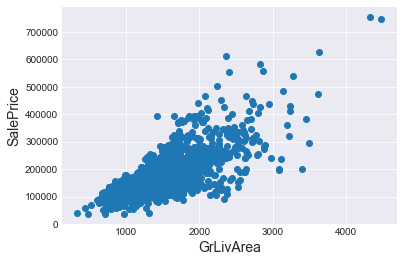

In [525]:
# Deleting outliers
data = data.drop(data[(data['GrLivArea']>4000) & (data['SalePrice']<300000)].index)
#Check in plot again
fig, ax = plt.subplots()
ax.scatter(data['GrLivArea'], data['SalePrice'])
plt.ylabel('SalePrice', fontsize=14)
plt.xlabel('GrLivArea', fontsize=14)
plt.show()

## Analysis on "SalePrice" (Target Variable) 

Let's do some analysis on this "SalePrice" variable first.


 sigma = 180932.92 and mu = 79467.79 



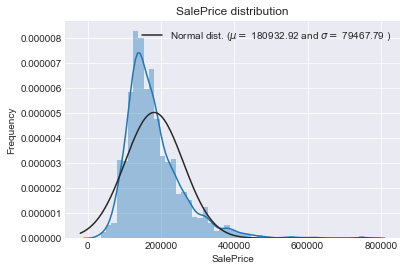

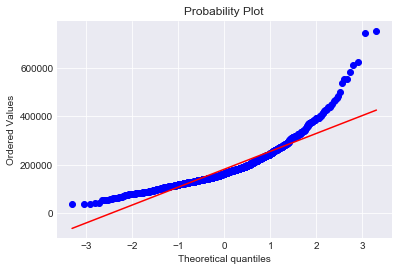

In [526]:
sns.distplot(data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['SalePrice'])
print( '\n sigma = {:.2f} and mu = {:.2f} \n'.format(mu, sigma))

# Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)
plt.show()

The target variable is now right skewed. As (linear) models would best fit with normally distributed data , so we need to transform this variable and make it more normally distributed.

## Log-transformation of the target variable


 mu = 12.02 and sigma = 0.40



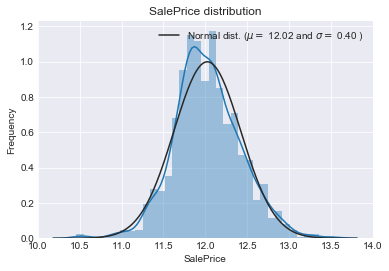

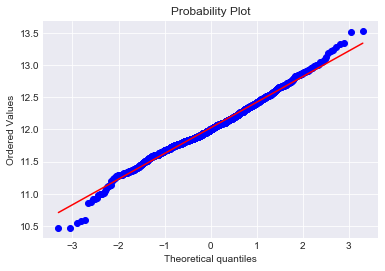

In [527]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data["SalePrice"] = np.log1p(data["SalePrice"])

# Check the new distribution 
sns.distplot(data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)
plt.show()

## Features engineering

In [528]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.588477
MiscFeature,96.296296
Alley,93.758573
Fence,80.727023
FireplaceQu,47.325103
LotFrontage,17.764060
GarageYrBlt,5.555556
GarageType,5.555556
GarageFinish,5.555556
GarageQual,5.555556


Text(0.5,1,'Percent missing data by feature')

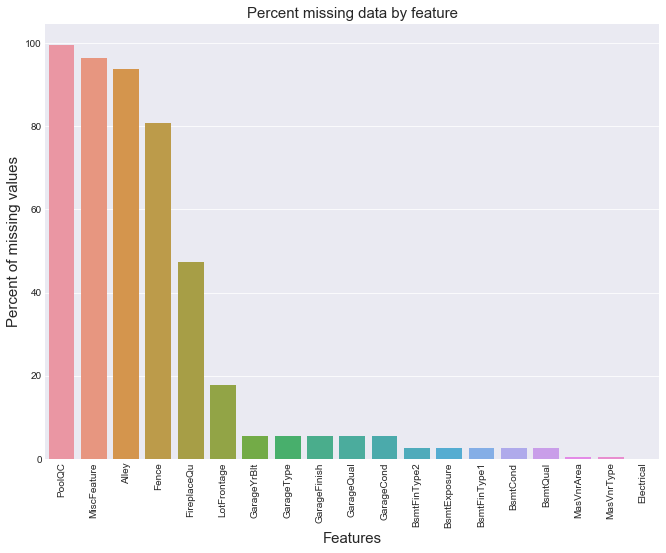

In [529]:
fig, ax = plt.subplots(figsize=(11, 8))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y=data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

## Data Correlation

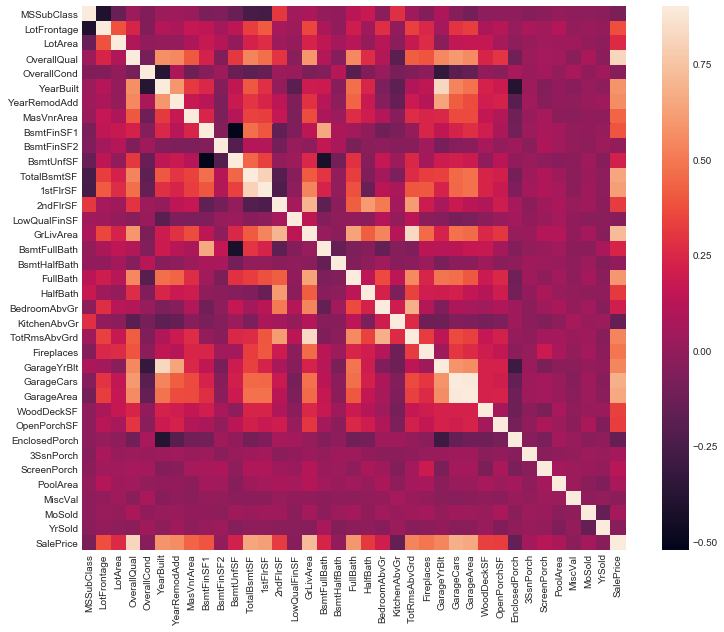

In [530]:
#Correlation map to see how features are correlated with SalePrice
correlation = data.corr()
plt.subplots(figsize=(13,10))
sns.heatmap(correlation, vmax=0.9, square=True)

In [531]:
#log transform the target:
data["SalePrice"] = np.log1p(data["SalePrice"])

#log transform skewed numeric features:
numeric_feats = data.dtypes[data.dtypes != "object"].index

skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data[skewed_feats] = np.log1p(data[skewed_feats])

C:\Users\praveen.nair\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log1p
  # This is added back by InteractiveShellApp.init_path()


In [532]:
#MSSubClass=The building class
data['MSSubClass'] = data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
data['OverallCond'] = data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)


from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

# shape        
print('Shape all_data: {}'.format(data.shape))

Shape all_data: (1458, 80)


## Getting dummy categorical features


In [533]:
data = pd.get_dummies(data)
#filling NA's with the mean of the column:
data = data.fillna(data.mean())
print(data.shape)

(1458, 220)


## Getting the new train and test sets.

In [534]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
X_train, X_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 100)

In [535]:
y = X_train.pop("SalePrice")

## Modelling

Now we are going to use regularized linear regression models from the scikit learn module. 
I'm going to try both Lasso and Ridge regularization.
I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par.

In [536]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [537]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data

In [538]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

Text(0,0.5,'rmse')

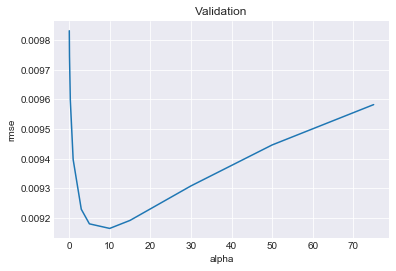

In [539]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [540]:
cv_ridge.min()

0.009164483619312946

So for the Ridge regression we get a rmsle of about 0.00916

In [548]:
model_lasso = LassoCV(alphas = [1, 0.01, 0.0001, 0.000003]).fit(X_train, y)

In [549]:
rmse_cv(model_lasso).mean()

0.00910279457045344

And For Lasso the rmsle is 0.00910

In [543]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [544]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 102 variables and eliminated the other 117 variables


In [545]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso Model')

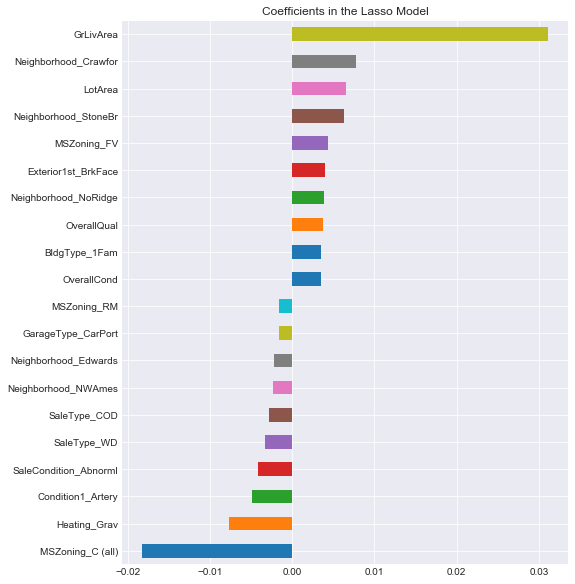

In [546]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is `GrLivArea` - the above ground area by area square feet. This definitely sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

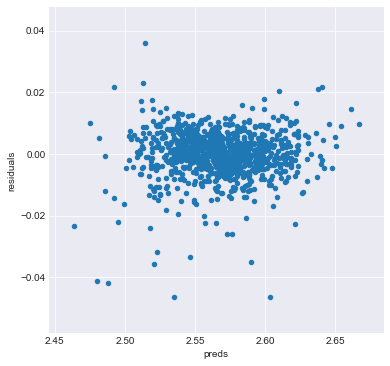

In [547]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")